In [2]:
import pandas as pd
import sys, os
import binotools as bt
from binotools import calbino
import astropy.stats

import numpy as np
import pylab as plt
import reionizer
import astropy.io.fits as fits

plt.style.use('seaborn-talk')
from matplotlib import rc_file
rc_file(os.environ['WORK_DIR']+'/code/matplotlibrc')

plt.rc('figure', dpi=150, figsize=(5,5))

# Combine fits files

In [12]:
files = bt.insensitive_glob('/h/hobnob0/Binospec/SAO-9/individual_frames/2019.0208/BLAS_1a_600_8500/reduced_series/obj_clean*_abs_slits_lin_fluxcalib.fits')
n_ob = len(files)
print(n_ob)

8


In [43]:
datadir  = os.environ['BINO_DIR']+'SAO-9/individual_frames/'
seeing_cut = 1.
# =====================================================================
# Load seeing list
seeing_filename = datadir+'seeing_PSF_arcsec.txt'
seeing_list     = pd.read_csv(seeing_filename, sep='\t', names=['fname','seeing'])

seeing_good = seeing_list[seeing_list.seeing < seeing_cut]

In [49]:
files = [frame_path.replace('.fits', '_fluxcalib.fits') for frame_path in seeing_good.fname]

n_ob = len(files)
print(n_ob)

47


# Get number of slits

In [108]:
hdu = fits.open(files[0])
print(len(hdu))

print(hdu[slit_i].data.shape)

175
(221, 5632)


In [109]:
slit_i = 1
for k, f in enumerate(files):
    hdu = fits.open(f)
    
    nslits = len(hdu)-1
    
    slit = hdu[slit_i].data
    
    if k == 0:
        nx1     = int(hdu[slit_i].header['NAXIS1'])
        ny1     = int(hdu[slit_i].header['NAXIS2'])
        print(nx1,ny1)
        print('Slit %i/%i  OB=%i/%i, ny    =%i' % (slit_i, nslits, k, n_ob, ny1))
       
        flux_cube = np.nan * np.ones((ny1, nx1, n_ob))
        err_cube  = np.nan * np.ones((ny1, nx1, n_ob))
        
        flux_cube[:,:,k] = slit

    else:
        ny_cur = hdu[slit_i].header['NAXIS2']  
        dy = int((ny1-ny_cur)/2.0)

        print('Slit %i/%i  OB=%i/%i, ny_cur=%i, dy=%i' % (slit_i, nslits, k, n_ob, ny_cur, dy))
        
        if dy > 0:
            flux_cube[dy:dy+ny_cur,:,k] = slit
        else:
            flux_cube[:,:,k] = slit[-dy:-dy+ny1,:]
    
print(flux_cube.shape)
#     plt.figure()
#     plt.imshow(slit.T)

5632 221
Slit 1/174  OB=0/47, ny    =221
Slit 1/174  OB=1/47, ny_cur=221, dy=0
Slit 1/174  OB=2/47, ny_cur=221, dy=0
Slit 1/174  OB=3/47, ny_cur=221, dy=0
Slit 1/174  OB=4/47, ny_cur=221, dy=0
Slit 1/174  OB=5/47, ny_cur=221, dy=0
Slit 1/174  OB=6/47, ny_cur=221, dy=0
Slit 1/174  OB=7/47, ny_cur=221, dy=0
Slit 1/174  OB=8/47, ny_cur=221, dy=0
Slit 1/174  OB=9/47, ny_cur=221, dy=0
Slit 1/174  OB=10/47, ny_cur=221, dy=0
Slit 1/174  OB=11/47, ny_cur=223, dy=-1
Slit 1/174  OB=12/47, ny_cur=223, dy=-1
Slit 1/174  OB=13/47, ny_cur=223, dy=-1
Slit 1/174  OB=14/47, ny_cur=223, dy=-1
Slit 1/174  OB=15/47, ny_cur=221, dy=0
Slit 1/174  OB=16/47, ny_cur=221, dy=0
Slit 1/174  OB=17/47, ny_cur=221, dy=0
Slit 1/174  OB=18/47, ny_cur=221, dy=0
Slit 1/174  OB=19/47, ny_cur=221, dy=0
Slit 1/174  OB=20/47, ny_cur=221, dy=0
Slit 1/174  OB=21/47, ny_cur=221, dy=0
Slit 1/174  OB=22/47, ny_cur=221, dy=0
Slit 1/174  OB=23/47, ny_cur=221, dy=0
Slit 1/174  OB=24/47, ny_cur=223, dy=-1
Slit 1/174  OB=25/47, ny_cu

/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1545: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: All-NaN slice encountered
  r = func(a, **kwargs)


(221, 5632)


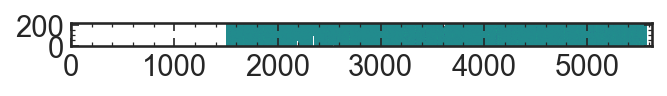

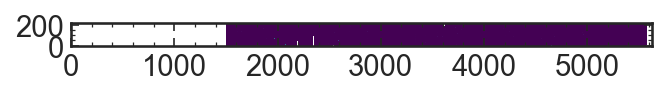

In [111]:
std_flux_cube = np.nanstd(flux_cube, axis=2)
med_flux_cube = np.nanmedian(flux_cube, axis=2)
print(med_flux_cube.shape)

plt.figure()
plt.imshow(med_flux_cube)

plt.figure()
plt.imshow(std_flux_cube)
 
flux_cube_clipped = astropy.stats.sigma_clip(flux_cube, sigma=3., axis=2, maxiters=5)
err_cube_clipped  = np.ma.array(err_cube, mask=flux_cube_clipped.mask)

(221, 5632)
-1.2810978520092236e-17 1.6335373117846938e-17


/home/cmason/anaconda2/envs/astroconda3/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: Mean of empty slice
  from ipykernel import kernelapp as app


(4000, 5000)

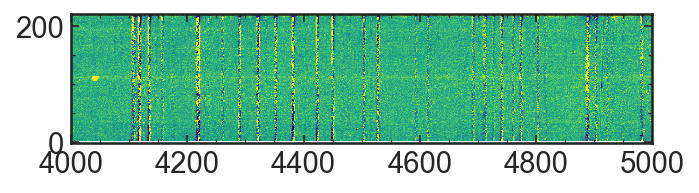

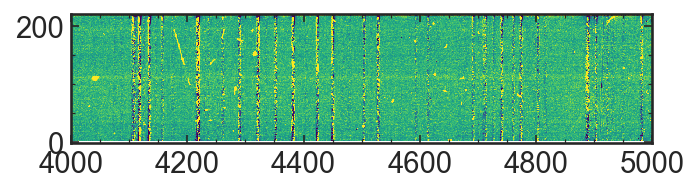

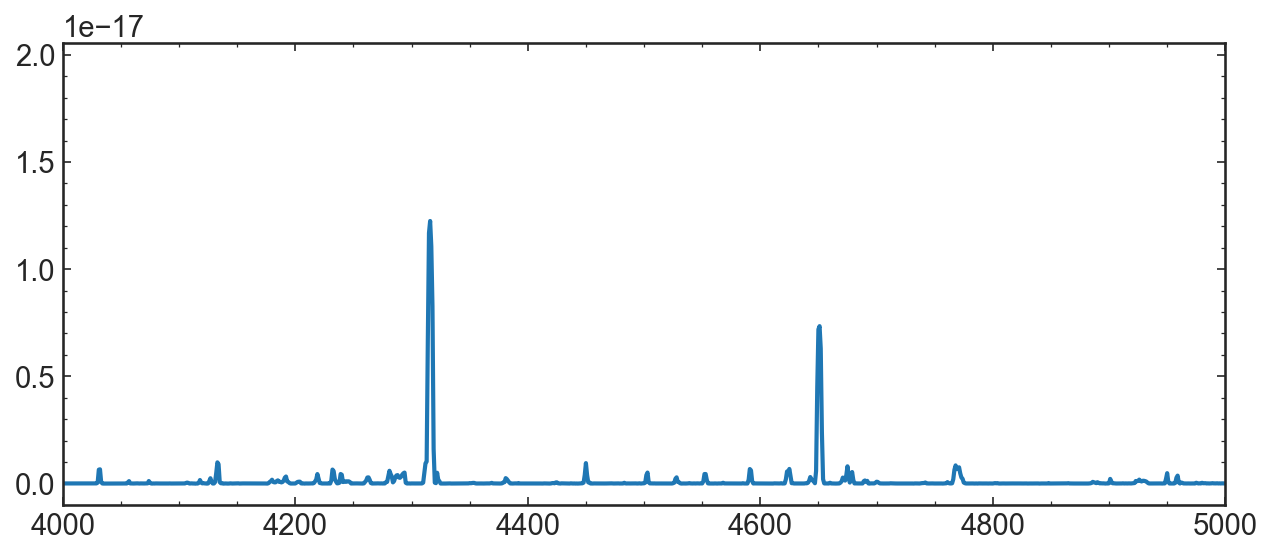

In [119]:
# Sigma clipped combined
flux_combined_clipped = np.nanmean(flux_cube_clipped, axis=2).filled(fill_value=np.nan)
print(flux_combined_clipped.shape)
print(np.nanmin(flux_combined_clipped), np.nanmax(flux_combined_clipped))
vmin=-0.5e-18
vmax=0.5e-18

plt.figure()
plt.imshow(flux_combined_clipped, vmin=vmin, vmax=vmax)
plt.xlim(1500, 5300)
plt.xlim(1500, 2000)
plt.xlim(4000, 5000)

# No clipping combined
flux_combined = np.nanmean(flux_cube, axis=2)

plt.figure()
plt.imshow(flux_combined, vmin=vmin, vmax=vmax)
plt.xlim(1500, 5300)
plt.xlim(1500, 2000)
plt.xlim(4000, 5000)

plt.figure(figsize=(10,4))
plt.plot(np.nanstd(flux_combined, axis=0) - np.nanstd(flux_combined_clipped, axis=0))
plt.xlim(1500, 5300)
plt.xlim(1500, 2000)
plt.xlim(4000, 5000)


# Check combined data

In [135]:
combinedir_Igor      = os.environ['BINO_DIR']+'SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-05/'
combinedir_sigmaclip = os.environ['BINO_DIR']+'SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-07/'

combine_Igor_file      = combinedir_Igor+'obj_clean000_abs_slits_lin_fluxcalib.fits'
combine_sigmaclip_file = combinedir_sigmaclip+'combined_fluxcalib_abs_slits_lin.fits'

/h/hobnob0/Binospec/SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-05/obj_clean000_abs_slits_lin_fluxcalib.fits
-1.3094111e-17 1.470598e-16
/h/hobnob0/Binospec/SAO-9/combined_fluxcalib/combine_47_frames_seeing<1.00arcsec_2019-11-07/combined_fluxcalib_abs_slits_lin.fits
-1.2907628904719812e-17 1.623138170395266e-17


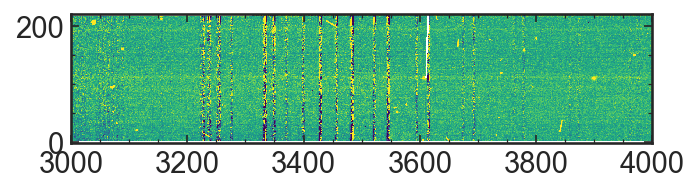

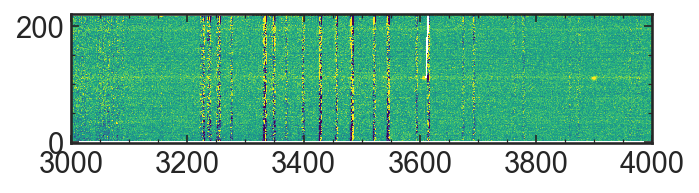

In [173]:
combine_files = [combine_Igor_file, combine_sigmaclip_file]

vmin=-0.5e-18
vmax=0.5e-18
for f in combine_files:
    print(f)
    
    hdulist = fits.open(f)
    
    slit = hdulist[1].data
    
    print(np.nanmin(slit), np.nanmax(slit))

    plt.figure()
    plt.imshow(slit, vmin=vmin, vmax=vmax)
    plt.xlim(3000, 4000)
#     plt.xlim(4300, 4700)

## Median subtract sky

In [155]:
hdulist = fits.open(combine_sigmaclip_file)

edge_pix = 3

dat2D_all = None
for i, slit in enumerate(hdulist):
    
    dat2D = slit.data
        
    if type(dat2D) == np.ndarray and i != 20 and i!=21:
        # exclude edges
        dat2D_noedge = dat2D[edge_pix:-edge_pix,:]

        if i == 1:
            dat2D_all = dat2D_noedge
        else:
            dat2D_all = np.vstack((dat2D_all, dat2D_noedge))

print(dat2D_all.shape)
master_sky = np.nanmedian(dat2D_all, axis=0)

(6032, 5632)


(3000, 4000)

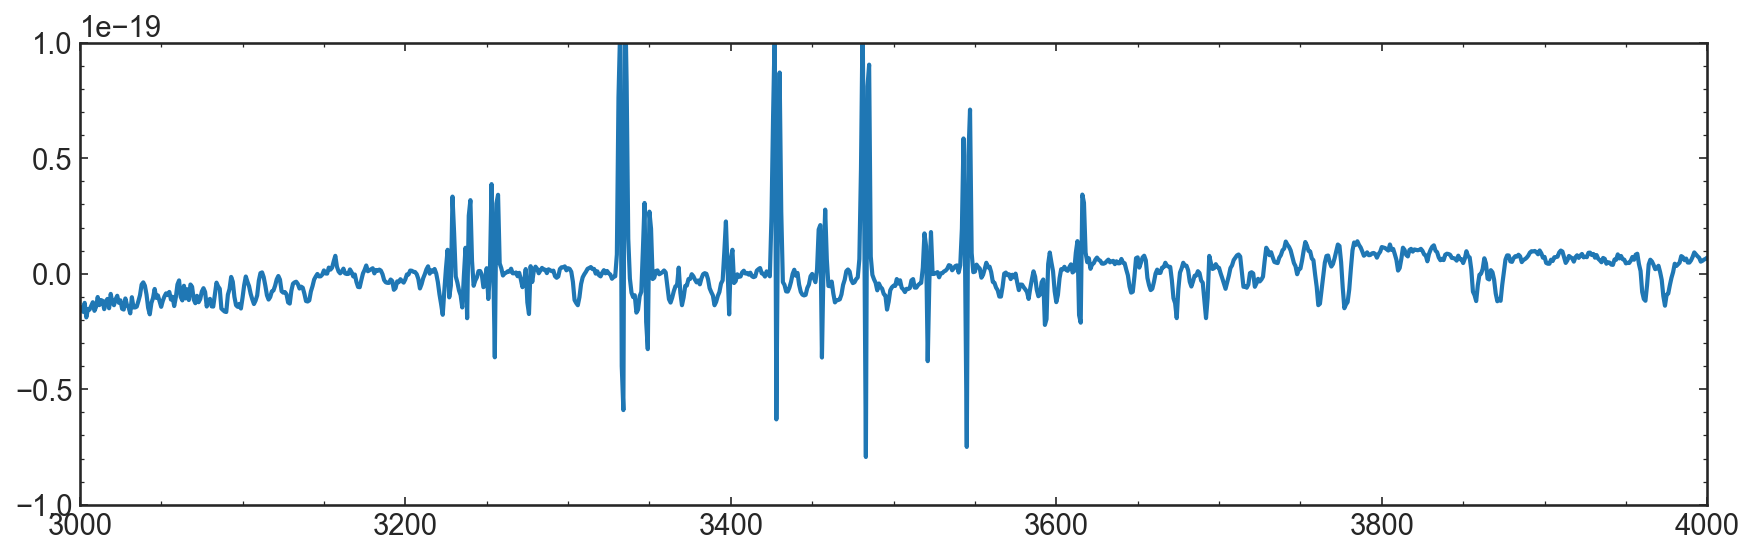

In [179]:
plt.figure(figsize=(14,4))

master_sky_med = master_sky - np.nanmedian(master_sky)
plt.plot(master_sky_med)

plt.ylim(-1e-19, 1e-19)
plt.xlim(3000, 4000)


(3000, 4000)

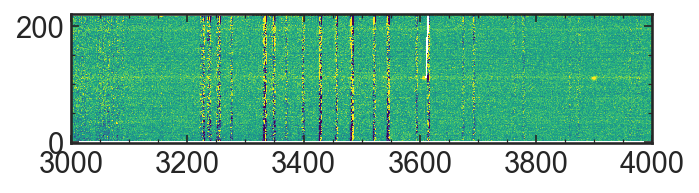

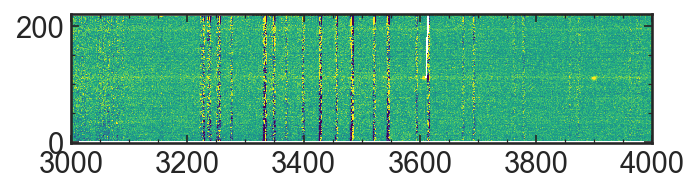

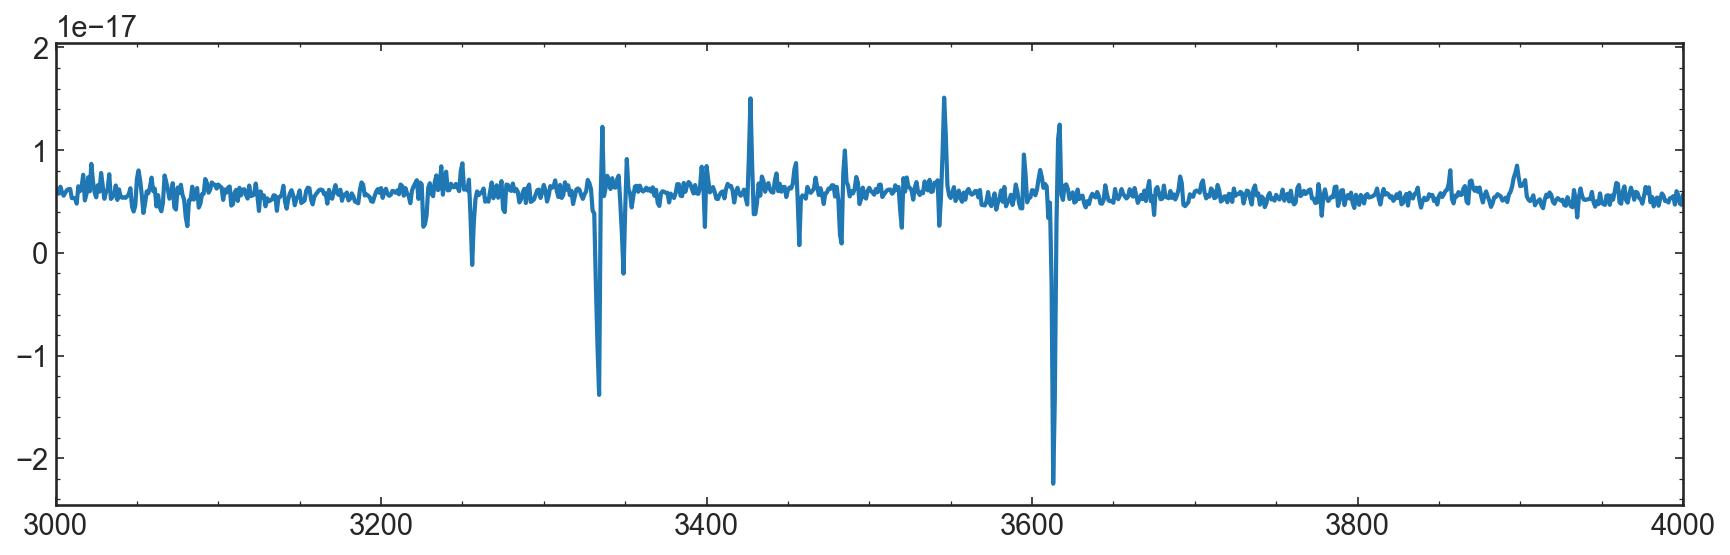

In [178]:
depth = 1e-19 #erg/s/cm^2/A
vmin=-5*depth
vmax=5*depth

slit = hdulist[1].data

plt.figure()
plt.imshow(slit, vmin=vmin, vmax=vmax)
plt.xlim(3000, 4000)

plt.figure()
plt.imshow(slit - master_sky_med, vmin=vmin, vmax=vmax)
plt.xlim(3000, 4000)

plt.figure(figsize=(14,4))
plt.plot(np.nansum(slit[80:120], axis=0))
plt.xlim(3000, 4000)


# Check sigma clipping algorithm

In [83]:
dat2D = np.ones((5,10))

N_frames = 100
dat3D = np.zeros((5,10,N_frames))
for i in range(N_frames):
    dat3D[:,:,i] = dat2D.copy()
    dat3D[np.random.randint(0, high=dat2D.shape[0]),np.random.randint(0, high=dat2D.shape[1]),i] = 100

(5, 10)


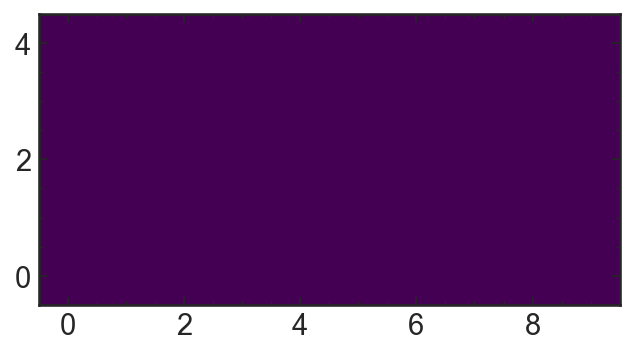

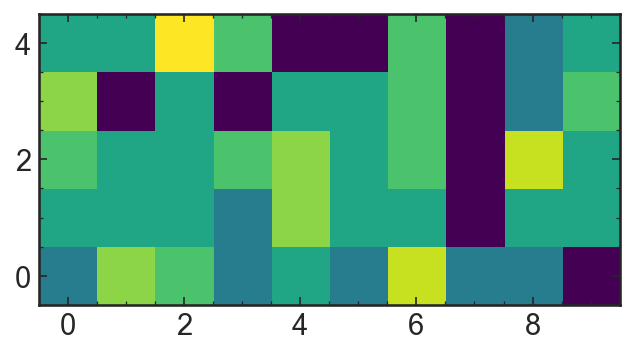

In [84]:
std_cube = np.nanstd(dat3D, axis=2)
med_cube = np.nanmedian(dat3D, axis=2)
print(med_cube.shape)

plt.figure()
plt.imshow(med_cube)

plt.figure()
plt.imshow(std_cube)
 
flux_cube_clipped = astropy.stats.sigma_clip(dat3D, sigma=3., axis=2, maxiters=3)

(5, 10)
1.0 1.0


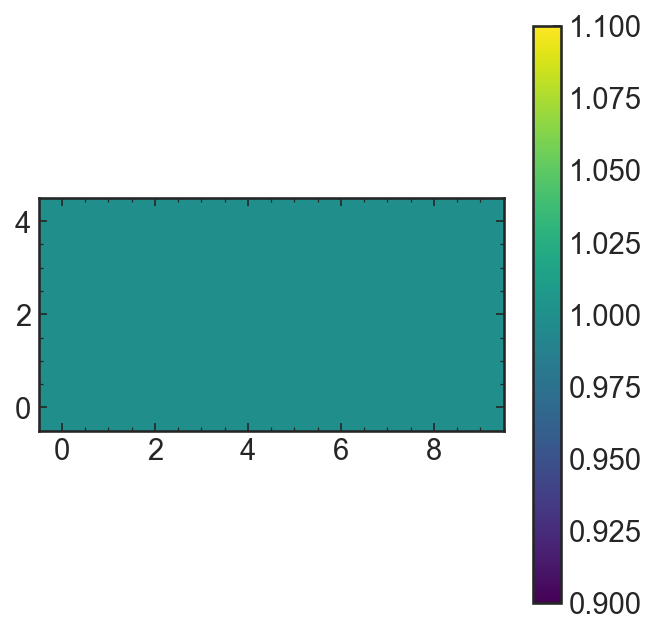

In [86]:
cube_clipped = np.nanmean(flux_cube_clipped, axis=2)
print(cube_clipped.shape)
print(np.nanmin(cube_clipped), np.nanmax(cube_clipped))

plt.figure()
plt.imshow(cube_clipped)
plt.colorbar()